In [12]:
require(tidyverse)
require(party)
require(mgcv)
require(lattice)
require(languageR)
require(repr)
require(itsadug)

In [13]:
nwdata = read_csv("../data/sense_graph/sense_graph_nonword.csv")


-- Column specification ------------------------------------------------------------------------------------------------
cols(
  .default = col_double(),
  Nonword_Trad = col_character(),
  Nonword_Sim = col_character(),
  C1 = col_character(),
  C2 = col_character(),
  word = col_character(),
  c1 = col_character(),
  c2 = col_character(),
  c1_node = col_character(),
  c2_node = col_character()
)
i<U+00A0>Use `spec()` for the full column specifications.




In [35]:
nwdata$RTinv = -1000/nwdata$RT
nwdata$log_freq_c1 = log(nwdata$`Google-freq-C1`)
nwdata$log_freq_c2 = log(nwdata$`Google-freq-C2`)
nwdata$log_c1_sfreq = log(nwdata$c1_sense_freq)
nwdata$log_c2_sfreq = log(nwdata$c2_sense_freq)
colnames(nwdata)[colnames(nwdata)=='Stroke-1'] = "stroke_c1"
colnames(nwdata)[colnames(nwdata)=='Stroke-2'] = "stroke_c2"
nwdata$min_dist_weighted = with(nwdata, sqrt(log_c1_sfreq+log_c2_sfreq)*min_dist)

In [36]:
names(nwdata)

[1] "Nonword_Trad"      "Nonword_Sim"       "Ntrials"          
 [4] "Acc"               "RT"                "RT-SE"            
 [7] "RT-SD"             "zRT"               "C1"               
[10] "C2"                "Google-freq-C1"    "stroke_c1"        
[13] "Google-freq-C2"    "stroke_c2"         "word"             
[16] "c1"                "c2"                "c1_node"          
[19] "c2_node"           "c1_sense_freq"     "c2_sense_freq"    
[22] "min_dist"          "morph_dw"          "morph_udw"        
[25] "morph_ds"          "morph_uds"         "c1_wD"            
[28] "c2_wD"             "RTinv"             "log_freq_c1"      
[31] "log_freq_c2"       "log_c1_sfreq"      "log_c2_sfreq"     
[34] "min_dist_weighted"

In [92]:
## helper function to plot interaction
popt = function(w, h, r=200) { options(repr.plot.width=w, repr.plot.height=h, repr.plot.res=r) }
plot_int = function(model, idx, x, y, ...){
    popt(12, 6)
    par(mfrow=c(1,2))
    suppressWarnings(plot(model, select=idx, lwd=2, labcex=1, ...))
    vis.gam(model, view=c(x, y), plot.type="contour", color="topo", too.far=0.1, ...)
}

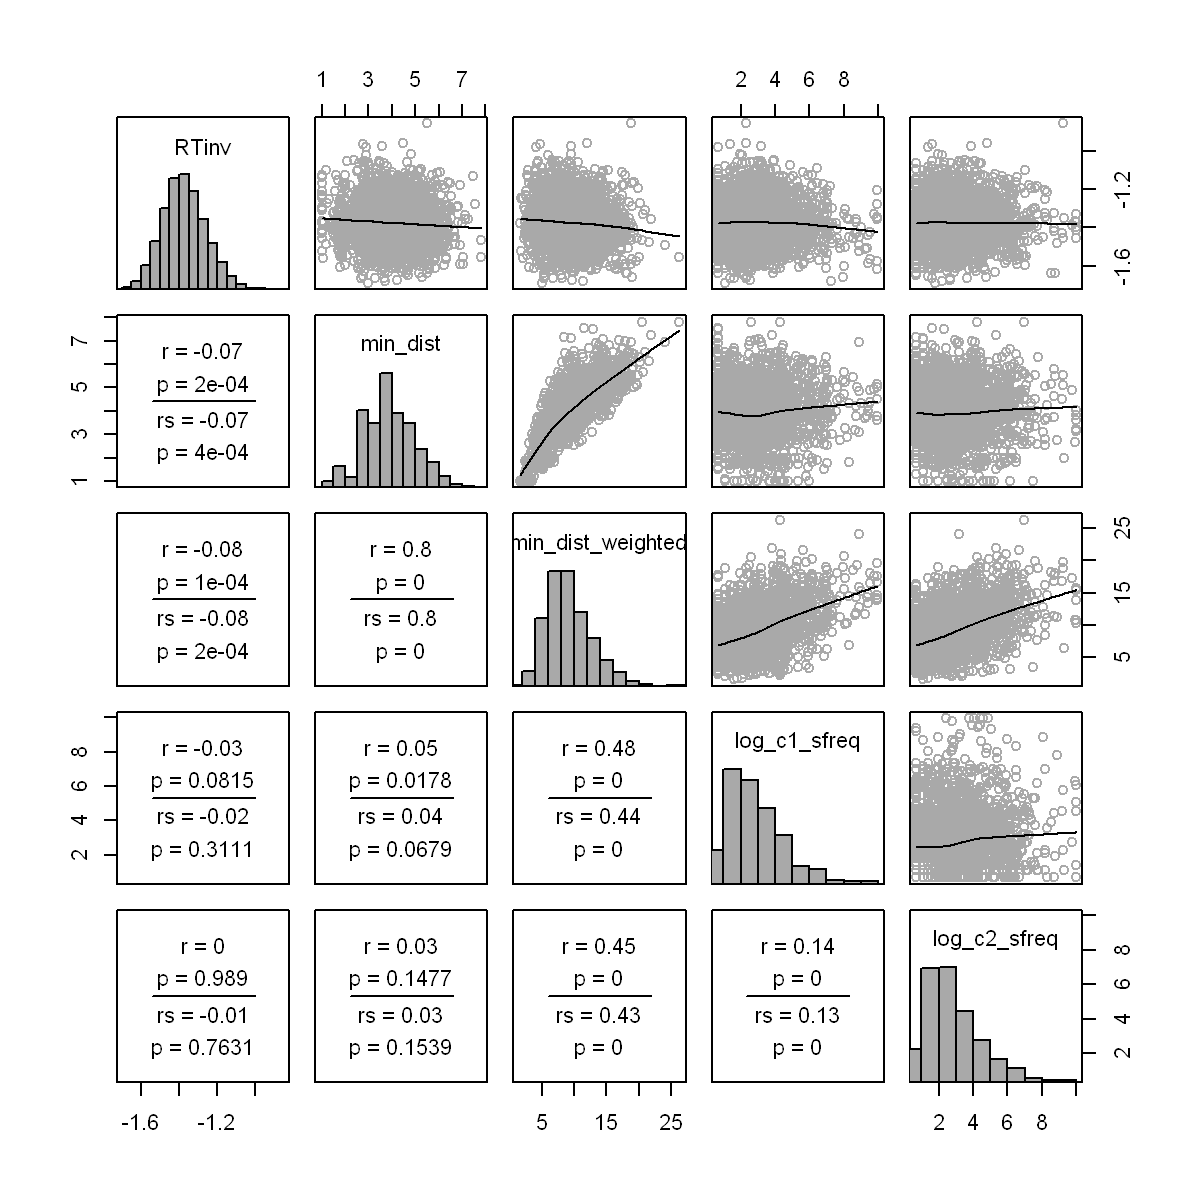

In [37]:
options(repr.plot.width=6, repr.plot.height=6, repr.plot.res=200)
pairscor.fnc(nwdata[,c("RTinv", "min_dist", "min_dist_weighted", "log_c1_sfreq", "log_c2_sfreq")])

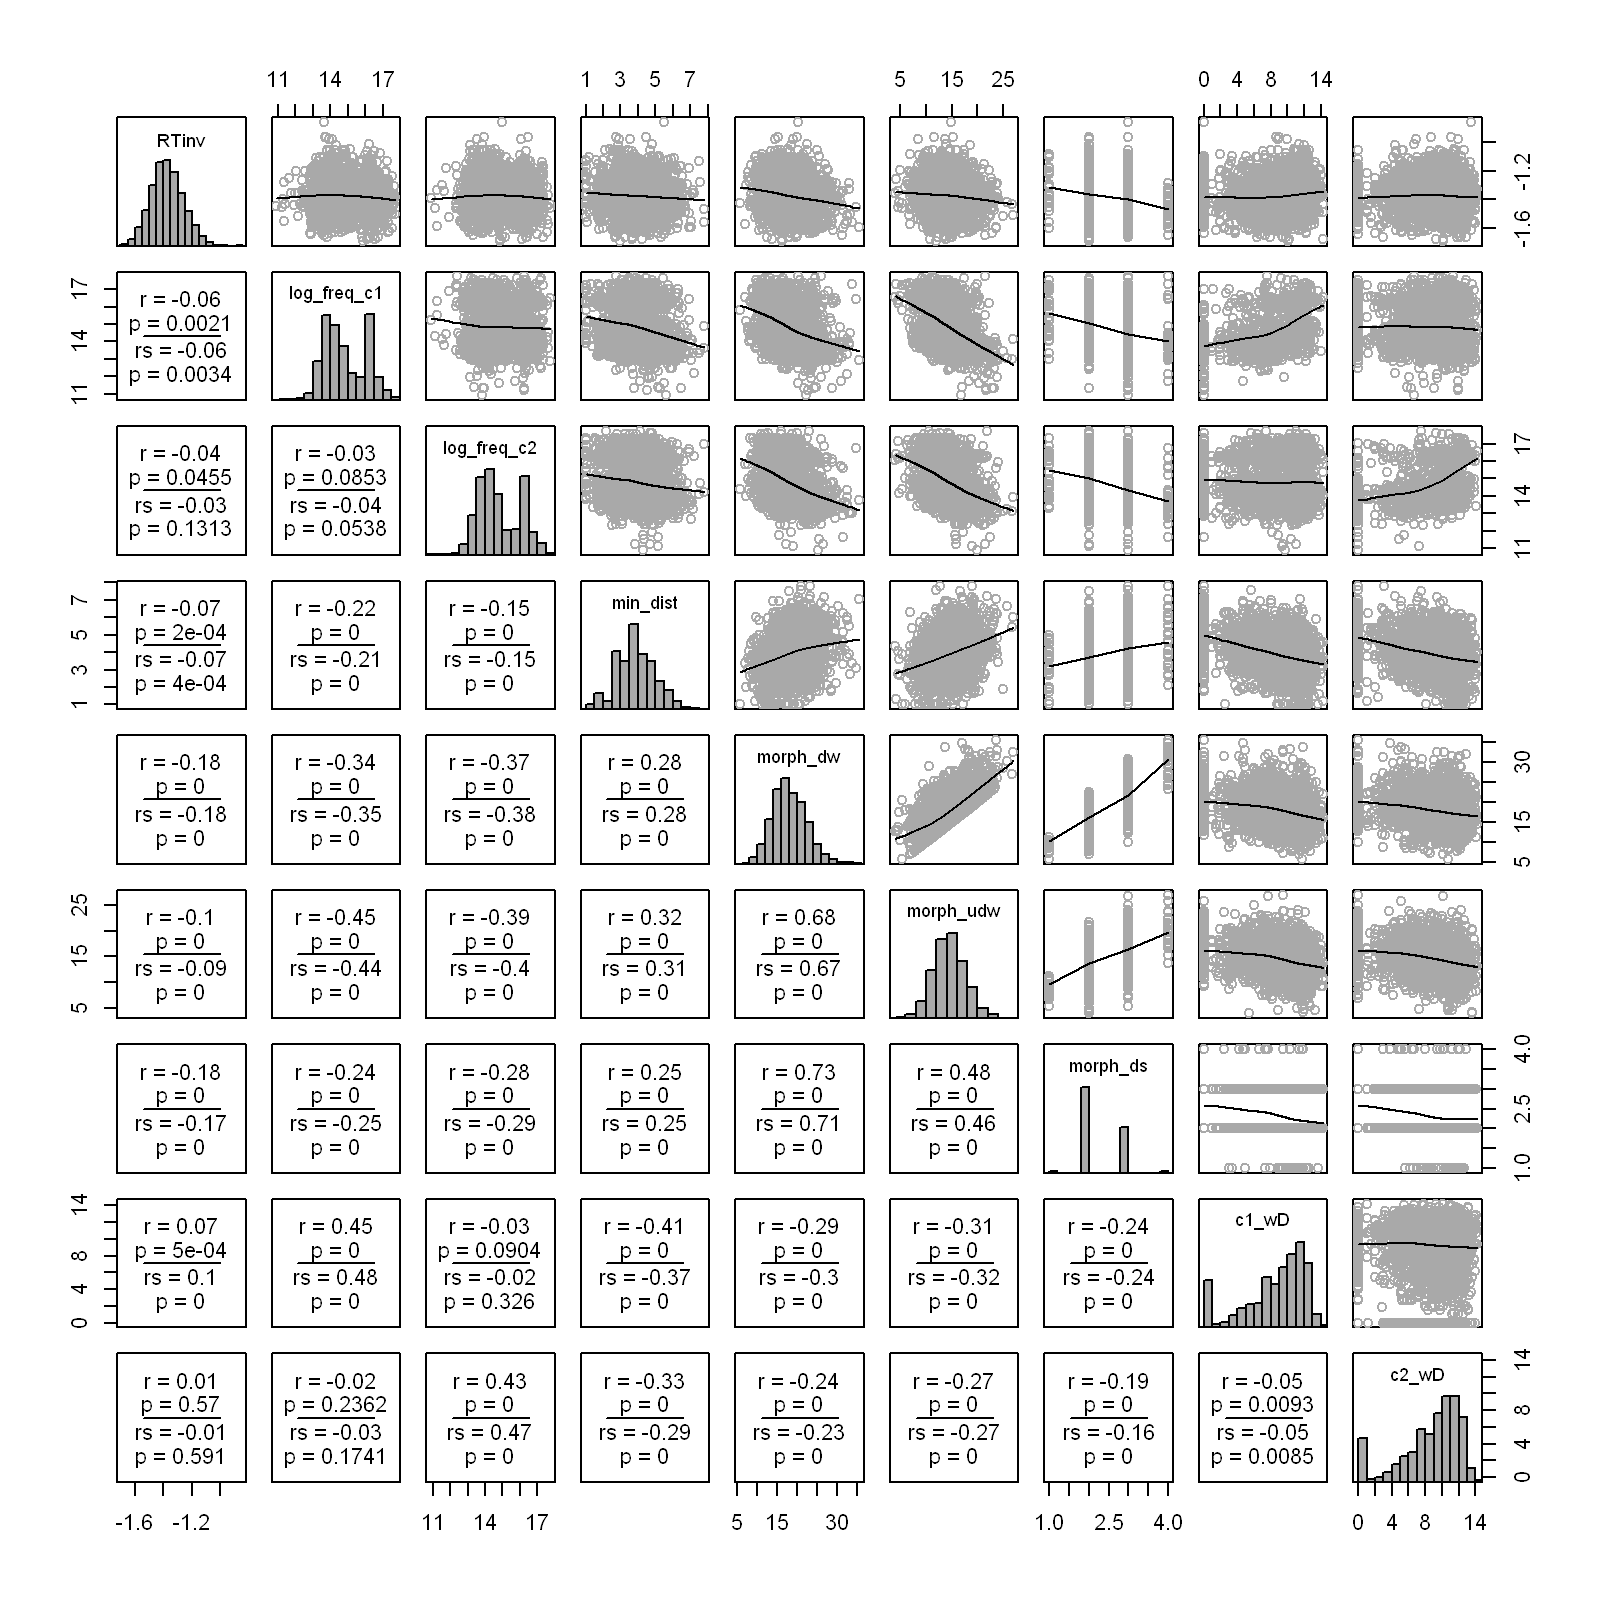

In [67]:
options(repr.plot.width=8, repr.plot.height=8, repr.plot.res=200)
pairscor.fnc(nwdata[,c("RTinv", "log_freq_c1", "log_freq_c2", "min_dist", "morph_dw", "morph_udw", "morph_ds", "c1_wD", "c2_wD")])

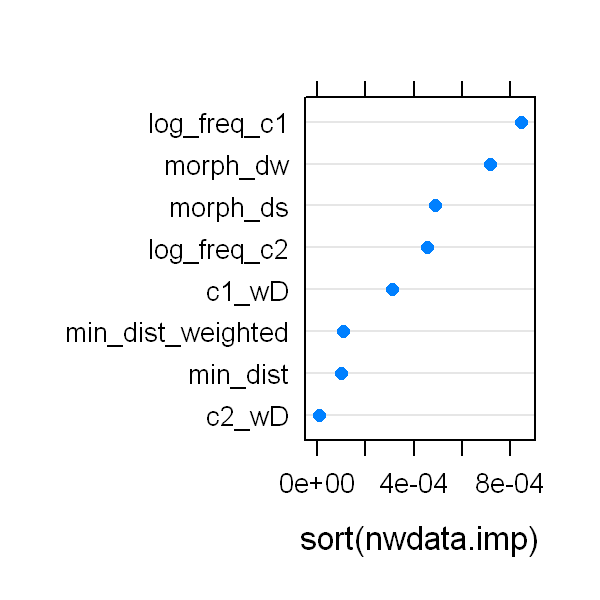

In [131]:
popt(3, 3, 200)
nwdata.cf = cforest(RTinv~., data=nwdata[,
                    c("RTinv", "log_freq_c1", "log_freq_c2", "min_dist", "min_dist_weighted", "morph_dw", "morph_ds", "c1_wD", "c2_wD")])
nwdata.imp = varimp(nwdata.cf)
dotplot(sort(nwdata.imp), main=list(cex=2))

## Model

In [58]:
m0 = bam(RTinv~s(log_freq_c1)+s(log_freq_c2), data=nwdata)
summary(m0)


Family: gaussian 
Link function: identity 

Formula:
RTinv ~ s(log_freq_c1) + s(log_freq_c2)

Parametric coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.372243   0.002262  -606.7   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
                 edf Ref.df     F p-value   
s(log_freq_c1) 2.680  3.437 4.597 0.00234 **
s(log_freq_c2) 2.212  2.840 2.685 0.04749 * 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-sq.(adj) =  0.00889   Deviance explained = 1.08%
fREML = -1883.6  Scale est. = 0.012753  n = 2493

In [132]:
m1 = bam(RTinv~s(log_freq_c1)+s(log_freq_c2)+s(morph_dw), data=nwdata)
summary(m1)


Family: gaussian 
Link function: identity 

Formula:
RTinv ~ s(log_freq_c1) + s(log_freq_c2) + s(morph_dw)

Parametric coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.372243   0.002191  -626.2   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
                 edf Ref.df      F p-value    
s(log_freq_c1) 1.064  1.126  58.02  <2e-16 ***
s(log_freq_c2) 1.000  1.000  54.49  <2e-16 ***
s(morph_dw)    1.000  1.000 174.31  <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-sq.(adj) =  0.0697   Deviance explained = 7.08%
fREML = -1960.1  Scale est. = 0.01197   n = 2493

In [133]:
m2 = bam(RTinv~s(log_freq_c1)+s(log_freq_c2)+s(min_dist)+s(morph_dw), data=nwdata)
summary(m2)


Family: gaussian 
Link function: identity 

Formula:
RTinv ~ s(log_freq_c1) + s(log_freq_c2) + s(min_dist) + s(morph_dw)

Parametric coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.372243   0.002189    -627   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
               edf Ref.df       F p-value    
s(log_freq_c1)   1      1  69.285 < 2e-16 ***
s(log_freq_c2)   1      1  57.465 < 2e-16 ***
s(min_dist)      1      1   7.274 0.00704 ** 
s(morph_dw)      1      1 156.999 < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-sq.(adj) =  0.072   Deviance explained = 7.35%
fREML = -1958.5  Scale est. = 0.011941  n = 2493

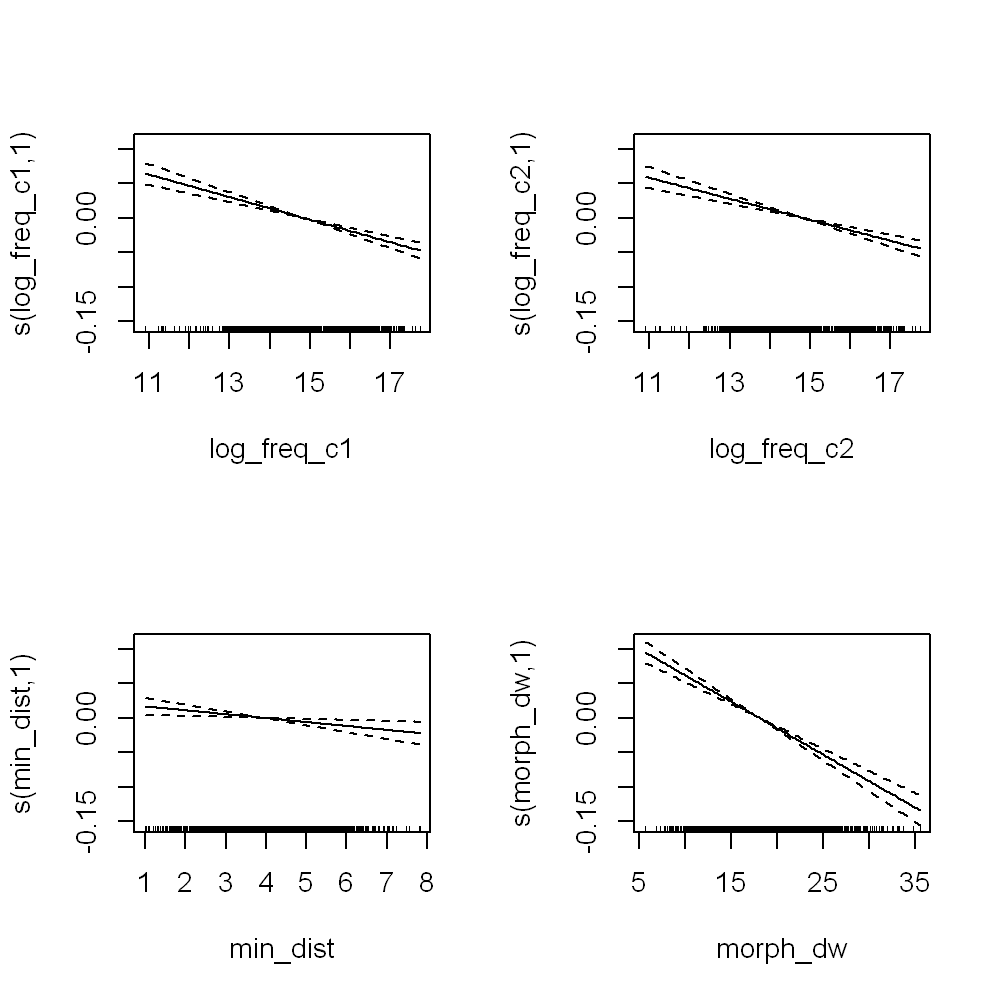

In [192]:
plot(m2, pages=1)

In [191]:
m3 = bam(RTinv~s(log_freq_c1)+s(log_freq_c2)+s(min_dist)+s(morph_dw)+s(c1_wD), data=nwdata)
summary(m3)


Family: gaussian 
Link function: identity 

Formula:
RTinv ~ s(log_freq_c1) + s(log_freq_c2) + s(min_dist) + s(morph_dw) + 
    s(c1_wD)

Parametric coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.372243   0.002178  -629.9   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
                 edf Ref.df       F p-value    
s(log_freq_c1) 1.000  1.000  82.357 < 2e-16 ***
s(log_freq_c2) 1.000  1.000  53.784 < 2e-16 ***
s(min_dist)    1.000  1.000   3.511  0.0611 .  
s(morph_dw)    1.000  1.000 143.251 < 2e-16 ***
s(c1_wD)       2.924  3.605   6.587 8.4e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-sq.(adj) =  0.0806   Deviance explained = 8.31%
fREML = -1963.6  Scale est. = 0.01183   n = 2493

In [135]:
m4 = bam(RTinv~s(log_freq_c1)+s(log_freq_c2)+s(morph_dw)+s(c1_wD), data=nwdata)
summary(m4)


Family: gaussian 
Link function: identity 

Formula:
RTinv ~ s(log_freq_c1) + s(log_freq_c2) + s(morph_dw) + s(c1_wD)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.37224    0.00218  -629.6   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
                 edf Ref.df       F  p-value    
s(log_freq_c1) 1.000  1.000  81.773  < 2e-16 ***
s(log_freq_c2) 1.000  1.000  51.274  < 2e-16 ***
s(morph_dw)    1.000  1.000 150.919  < 2e-16 ***
s(c1_wD)       2.907  3.584   7.677 1.65e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-sq.(adj) =  0.0796   Deviance explained = 8.18%
fREML =  -1967  Scale est. = 0.011842  n = 2493

In [136]:
AIC(m0, m1, m2, m3, m4)

,df,AIC
,<dbl>,<dbl>
m0,7.881972,-3789.799
m1,5.125962,-3951.314
m2,6.000189,-3956.713
m3,9.129428,-3976.527
m4,8.114776,-3974.972


## Diving into M4: morph_dw & c1_wD

In [141]:
summary(m4)


Family: gaussian 
Link function: identity 

Formula:
RTinv ~ s(log_freq_c1) + s(log_freq_c2) + s(morph_dw) + s(c1_wD)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.37224    0.00218  -629.6   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
                 edf Ref.df       F  p-value    
s(log_freq_c1) 1.000  1.000  81.773  < 2e-16 ***
s(log_freq_c2) 1.000  1.000  51.274  < 2e-16 ***
s(morph_dw)    1.000  1.000 150.919  < 2e-16 ***
s(c1_wD)       2.907  3.584   7.677 1.65e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-sq.(adj) =  0.0796   Deviance explained = 8.18%
fREML =  -1967  Scale est. = 0.011842  n = 2493

In [137]:
m4.1 = bam(RTinv~te(log_freq_c1, log_freq_c2)+s(morph_dw)+s(c1_wD), data=nwdata)
summary(m4.1)


Family: gaussian 
Link function: identity 

Formula:
RTinv ~ te(log_freq_c1, log_freq_c2) + s(morph_dw) + s(c1_wD)

Parametric coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.372243   0.002179  -629.6   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
                              edf Ref.df       F  p-value    
te(log_freq_c1,log_freq_c2) 3.000  3.000  39.675  < 2e-16 ***
s(morph_dw)                 1.000  1.000 151.023  < 2e-16 ***
s(c1_wD)                    2.904  3.581   7.644 1.75e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-sq.(adj) =  0.0797   Deviance explained = 8.23%
fREML = -1970.9  Scale est. = 0.011841  n = 2493

In [138]:
m4.2 = bam(RTinv~s(log_freq_c1)+s(log_freq_c2)+te(morph_dw, c1_wD), data=nwdata)
summary(m4.2)


Family: gaussian 
Link function: identity 

Formula:
RTinv ~ s(log_freq_c1) + s(log_freq_c2) + te(morph_dw, c1_wD)

Parametric coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.372243   0.002179  -629.7   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
                     edf Ref.df     F p-value    
s(log_freq_c1)     1.105  1.204 70.24  <2e-16 ***
s(log_freq_c2)     1.000  1.000 51.96  <2e-16 ***
te(morph_dw,c1_wD) 6.201  7.907 25.88  <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-sq.(adj) =  0.0798   Deviance explained = 8.29%
fREML = -1970.1  Scale est. = 0.01184   n = 2493

## M3: morph_dw and min_dist x c1_wD

In [152]:
m3.1 = bam(RTinv~s(log_freq_c1)+s(log_freq_c2)+s(morph_dw)+te(min_dist, c1_wD), data=nwdata)
summary(m3.1)


Family: gaussian 
Link function: identity 

Formula:
RTinv ~ s(log_freq_c1) + s(log_freq_c2) + s(morph_dw) + te(min_dist, 
    c1_wD)

Parametric coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.372243   0.002177  -630.4   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
                     edf Ref.df       F  p-value    
s(log_freq_c1)     1.000  1.000  84.416  < 2e-16 ***
s(log_freq_c2)     1.000  1.000  54.289  < 2e-16 ***
s(morph_dw)        1.000  1.000 143.248  < 2e-16 ***
te(min_dist,c1_wD) 4.902  5.693   6.303 3.33e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-sq.(adj) =  0.0819   Deviance explained = 8.48%
fREML = -1968.9  Scale est. = 0.011814  n = 2493

In [153]:
AIC(m4, m4.1, m4.2, m3.1)

,df,AIC
,<dbl>,<dbl>
m4,8.114776,-3974.972
m4.1,9.108635,-3974.197
m4.2,12.110215,-3969.870
m3.1,10.294882,-3978.621


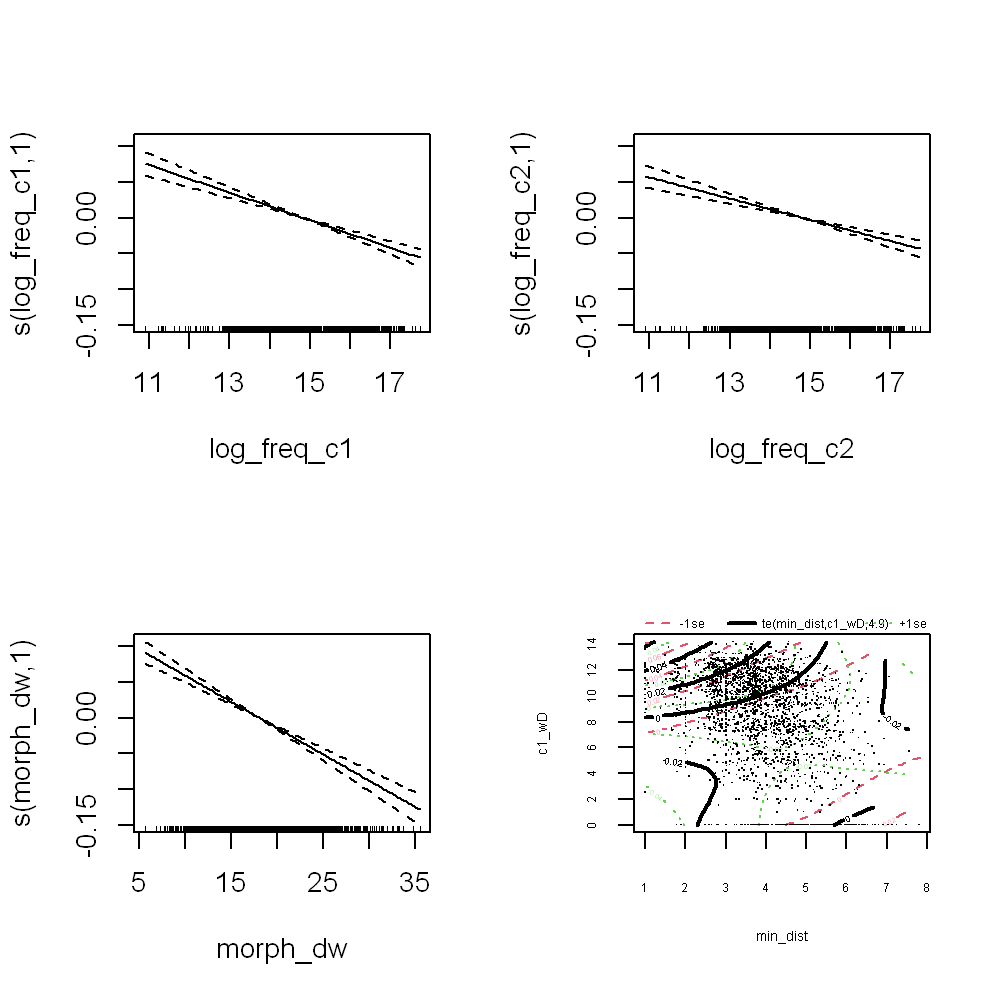

In [165]:
popt(5, 5)
plot(m3.1, pages=1)

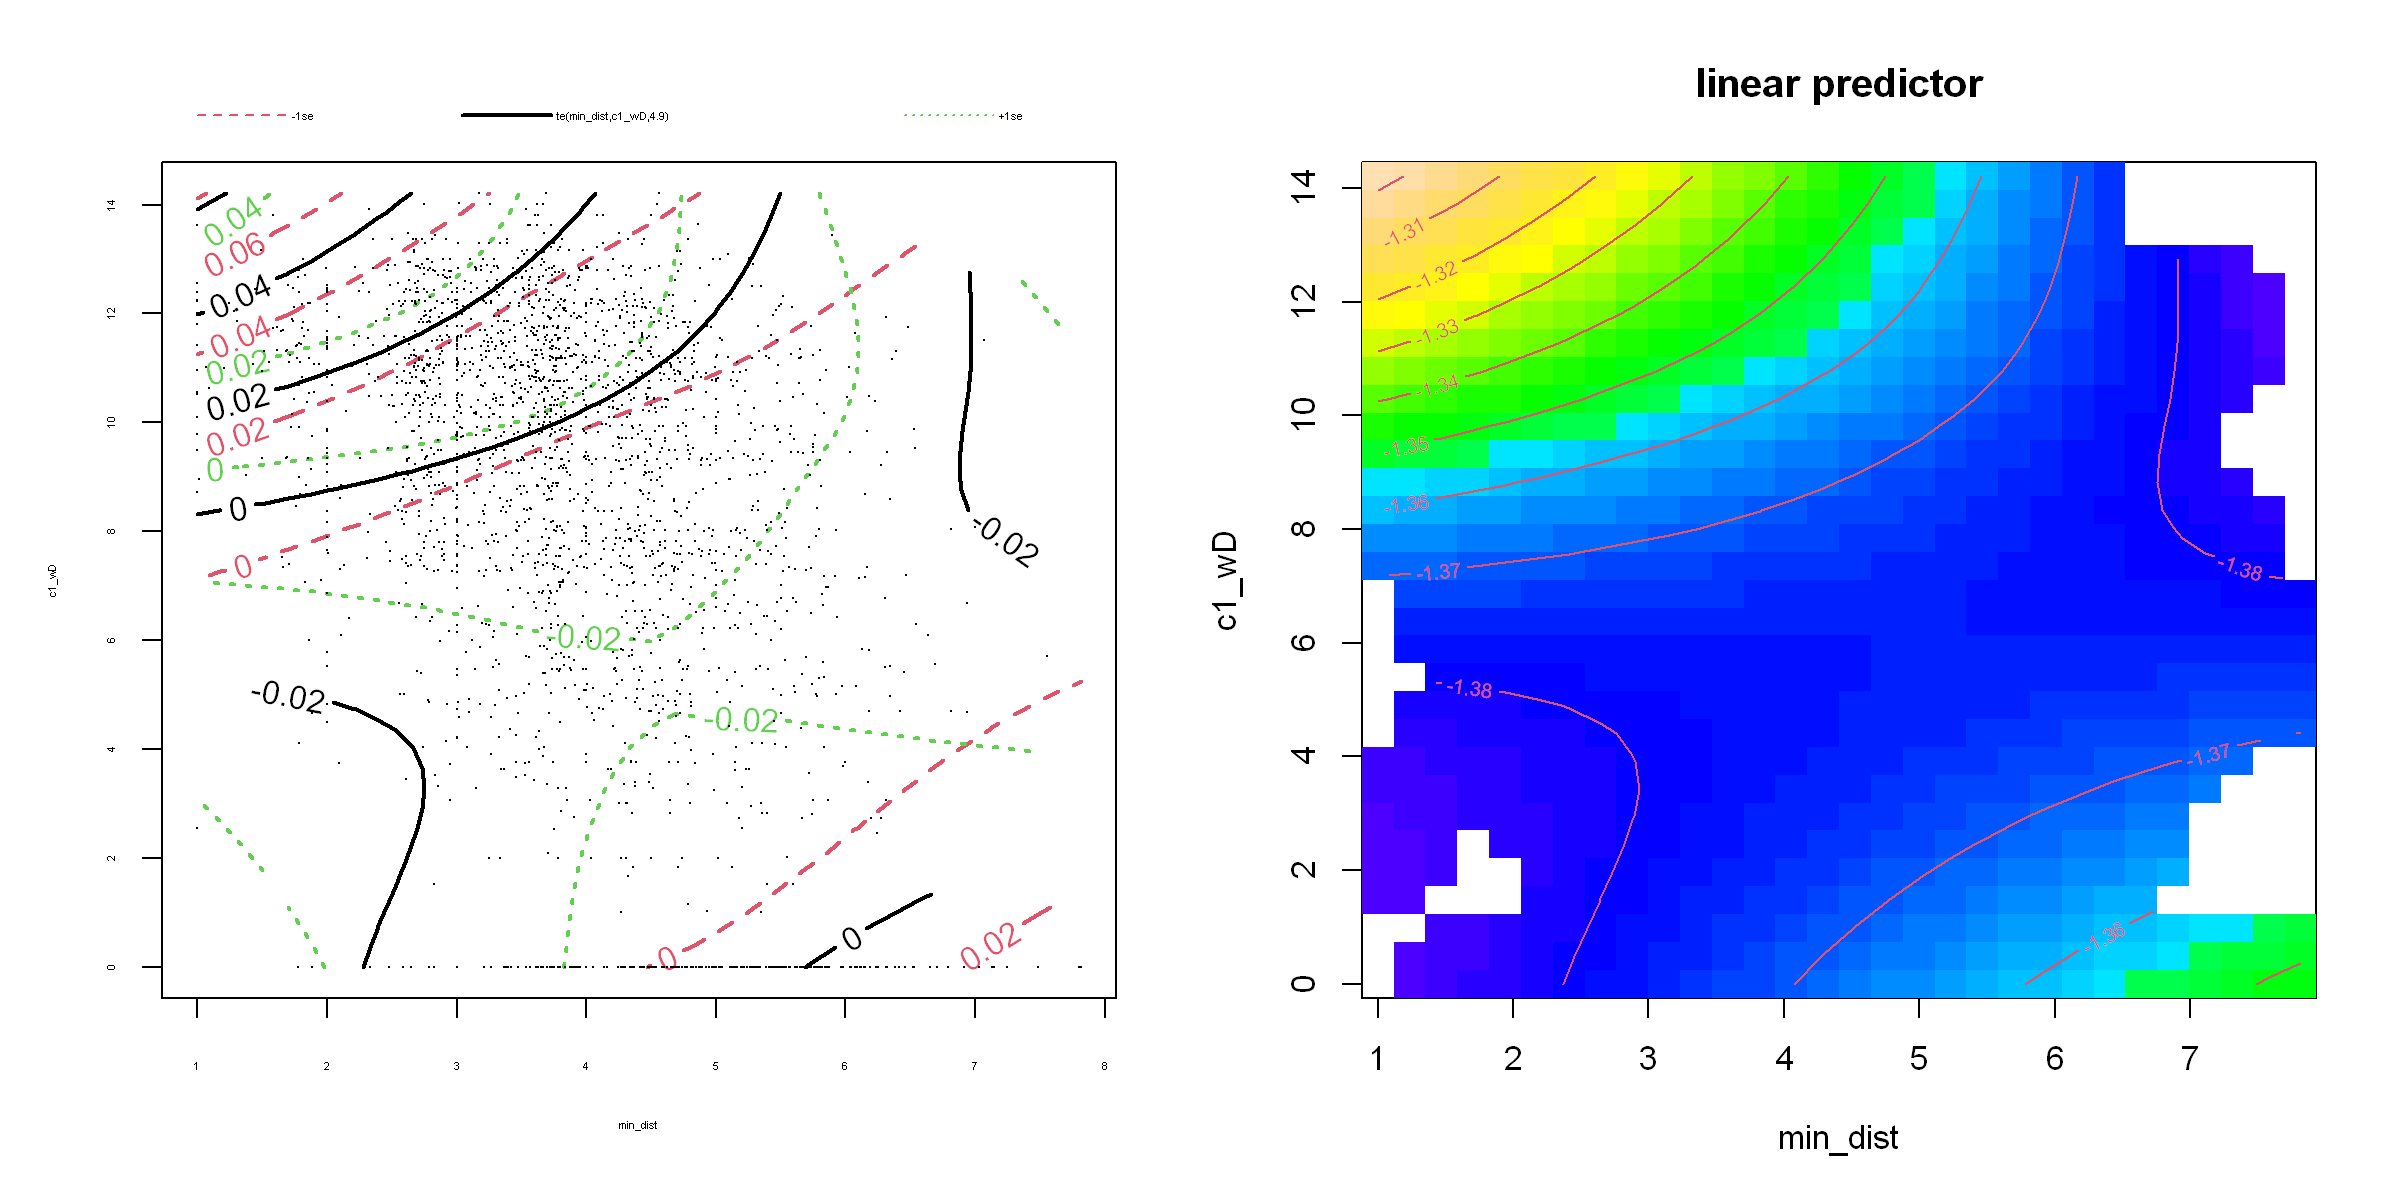

In [166]:
plot_int(m3.1, 4, "min_dist", "c1_wD")

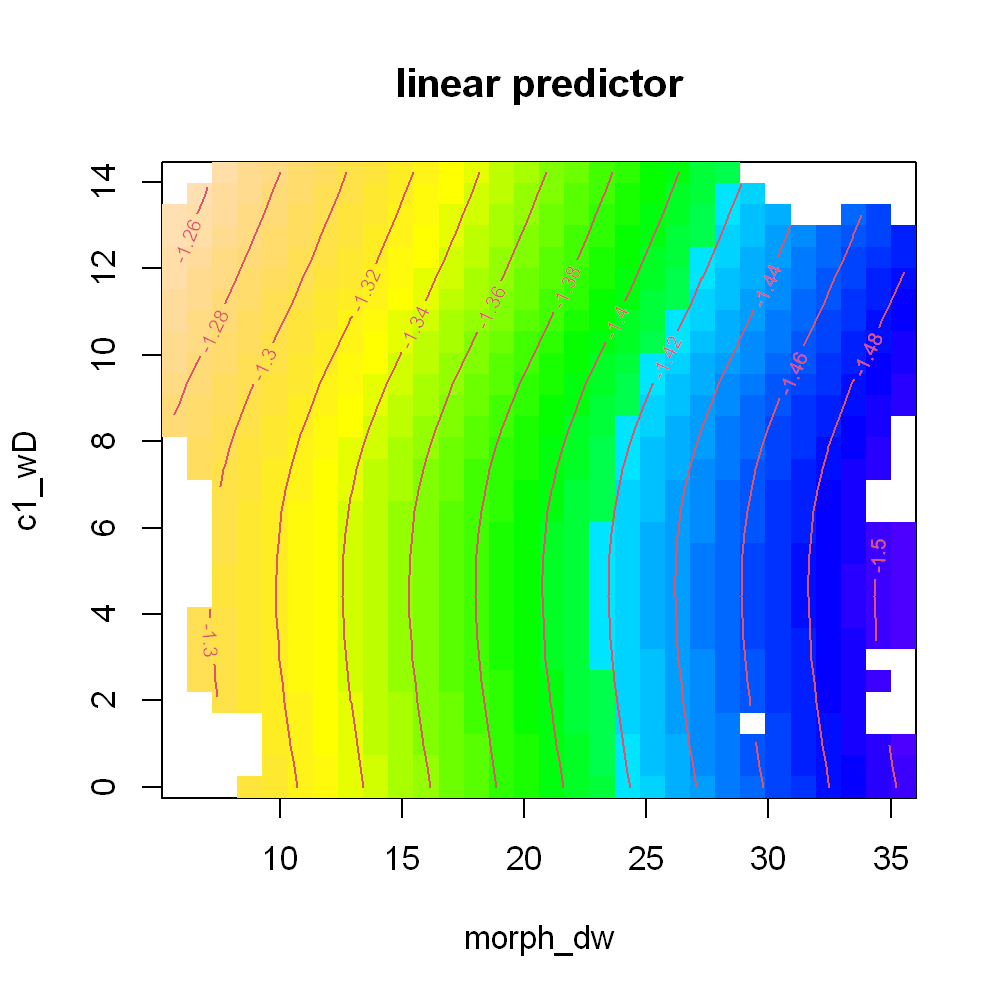

In [168]:
popt(5, 5)
vis.gam(m3.1, c("morph_dw", "c1_wD"), plot.type="contour", color="topo", too.far=0.1)

## Is Acc relevant??

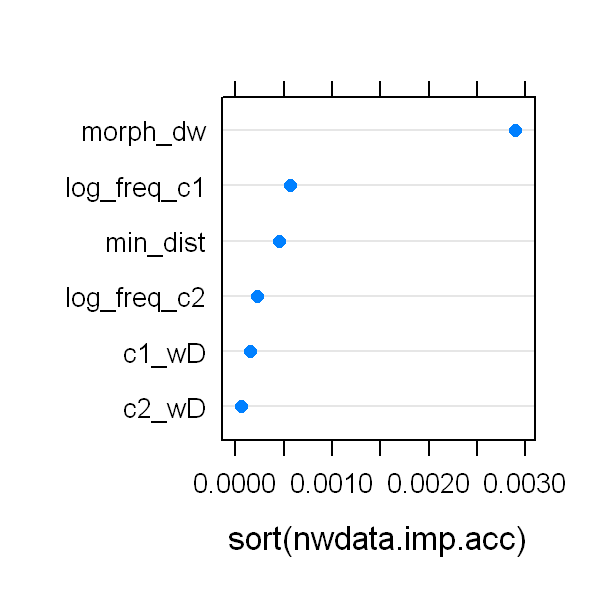

In [109]:
popt(3, 3, 200)
nwdata.cf.acc = cforest(Acc~., data=nwdata[,
                    c("Acc", "log_freq_c1", "log_freq_c2", "min_dist", "morph_dw", "c1_wD", "c2_wD")])
nwdata.imp.acc = varimp(nwdata.cf.acc)
dotplot(sort(nwdata.imp.acc), main=list(cex=2))

In [158]:
ma2 = bam(Acc~s(log_freq_c1)+s(log_freq_c2)+s(min_dist)+s(morph_dw), data=nwdata)
summary(ma2)


Family: gaussian 
Link function: identity 

Formula:
Acc ~ s(log_freq_c1) + s(log_freq_c2) + s(min_dist) + s(morph_dw)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.890923   0.002204   404.2   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
                 edf Ref.df      F  p-value    
s(log_freq_c1) 1.000  1.000 34.845  < 2e-16 ***
s(log_freq_c2) 1.000  1.000 22.125 3.02e-06 ***
s(min_dist)    1.686  2.136  7.349 0.000536 ***
s(morph_dw)    2.051  2.632 76.214  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-sq.(adj) =  0.0891   Deviance explained = 9.12%
fREML = -1939.5  Scale est. = 0.012114  n = 2493

In [159]:
ma2.1 = bam(Acc~s(log_freq_c1)+s(log_freq_c2)+te(min_dist, morph_dw), data=nwdata)
summary(ma2.1)


Family: gaussian 
Link function: identity 

Formula:
Acc ~ s(log_freq_c1) + s(log_freq_c2) + te(min_dist, morph_dw)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.890923   0.002201   404.8   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
                        edf Ref.df     F  p-value    
s(log_freq_c1)        1.000   1.00 34.80  < 2e-16 ***
s(log_freq_c2)        1.000   1.00 22.22 2.86e-06 ***
te(min_dist,morph_dw) 7.684  10.01 25.22  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-sq.(adj) =  0.0919   Deviance explained = 9.54%
fREML = -1945.3  Scale est. = 0.012077  n = 2493

In [160]:
ma3 = bam(Acc~s(log_freq_c1)+s(log_freq_c2)+s(min_dist)+s(morph_dw)+s(c1_wD), data=nwdata)
summary(ma3)


Family: gaussian 
Link function: identity 

Formula:
Acc ~ s(log_freq_c1) + s(log_freq_c2) + s(min_dist) + s(morph_dw) + 
    s(c1_wD)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.890923   0.002202   404.6   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
                 edf Ref.df      F  p-value    
s(log_freq_c1) 1.000  1.000 35.865  < 2e-16 ***
s(log_freq_c2) 1.000  1.000 21.382 4.53e-06 ***
s(min_dist)    1.556  1.951  7.124  0.00201 ** 
s(morph_dw)    1.991  2.554 75.099  < 2e-16 ***
s(c1_wD)       2.347  2.897  1.949  0.11584    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-sq.(adj) =  0.0909   Deviance explained = 9.37%
fREML = -1936.4  Scale est. = 0.01209   n = 2493

In [155]:
ma3.1 = bam(Acc~s(log_freq_c1)+s(log_freq_c2)+s(morph_dw)+te(min_dist, c1_wD), data=nwdata)
summary(ma3.1)


Family: gaussian 
Link function: identity 

Formula:
Acc ~ s(log_freq_c1) + s(log_freq_c2) + s(morph_dw) + te(min_dist, 
    c1_wD)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.890923   0.002202   404.6   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
                     edf Ref.df      F  p-value    
s(log_freq_c1)     1.000  1.000 36.168  < 2e-16 ***
s(log_freq_c2)     1.000  1.000 21.681 3.84e-06 ***
s(morph_dw)        1.918  2.458 77.897  < 2e-16 ***
te(min_dist,c1_wD) 4.023  4.635  4.815 0.000358 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-sq.(adj) =  0.0908   Deviance explained = 9.37%
fREML = -1940.4  Scale est. = 0.012091  n = 2493

In [161]:
AIC(ma2, ma2.1, ma3, ma3.1)

,df,AIC
,<dbl>,<dbl>
ma2,8.768733,-3917.027
ma2.1,12.844184,-3920.440
ma3,11.403188,-3918.749
ma3.1,11.093524,-3919.338


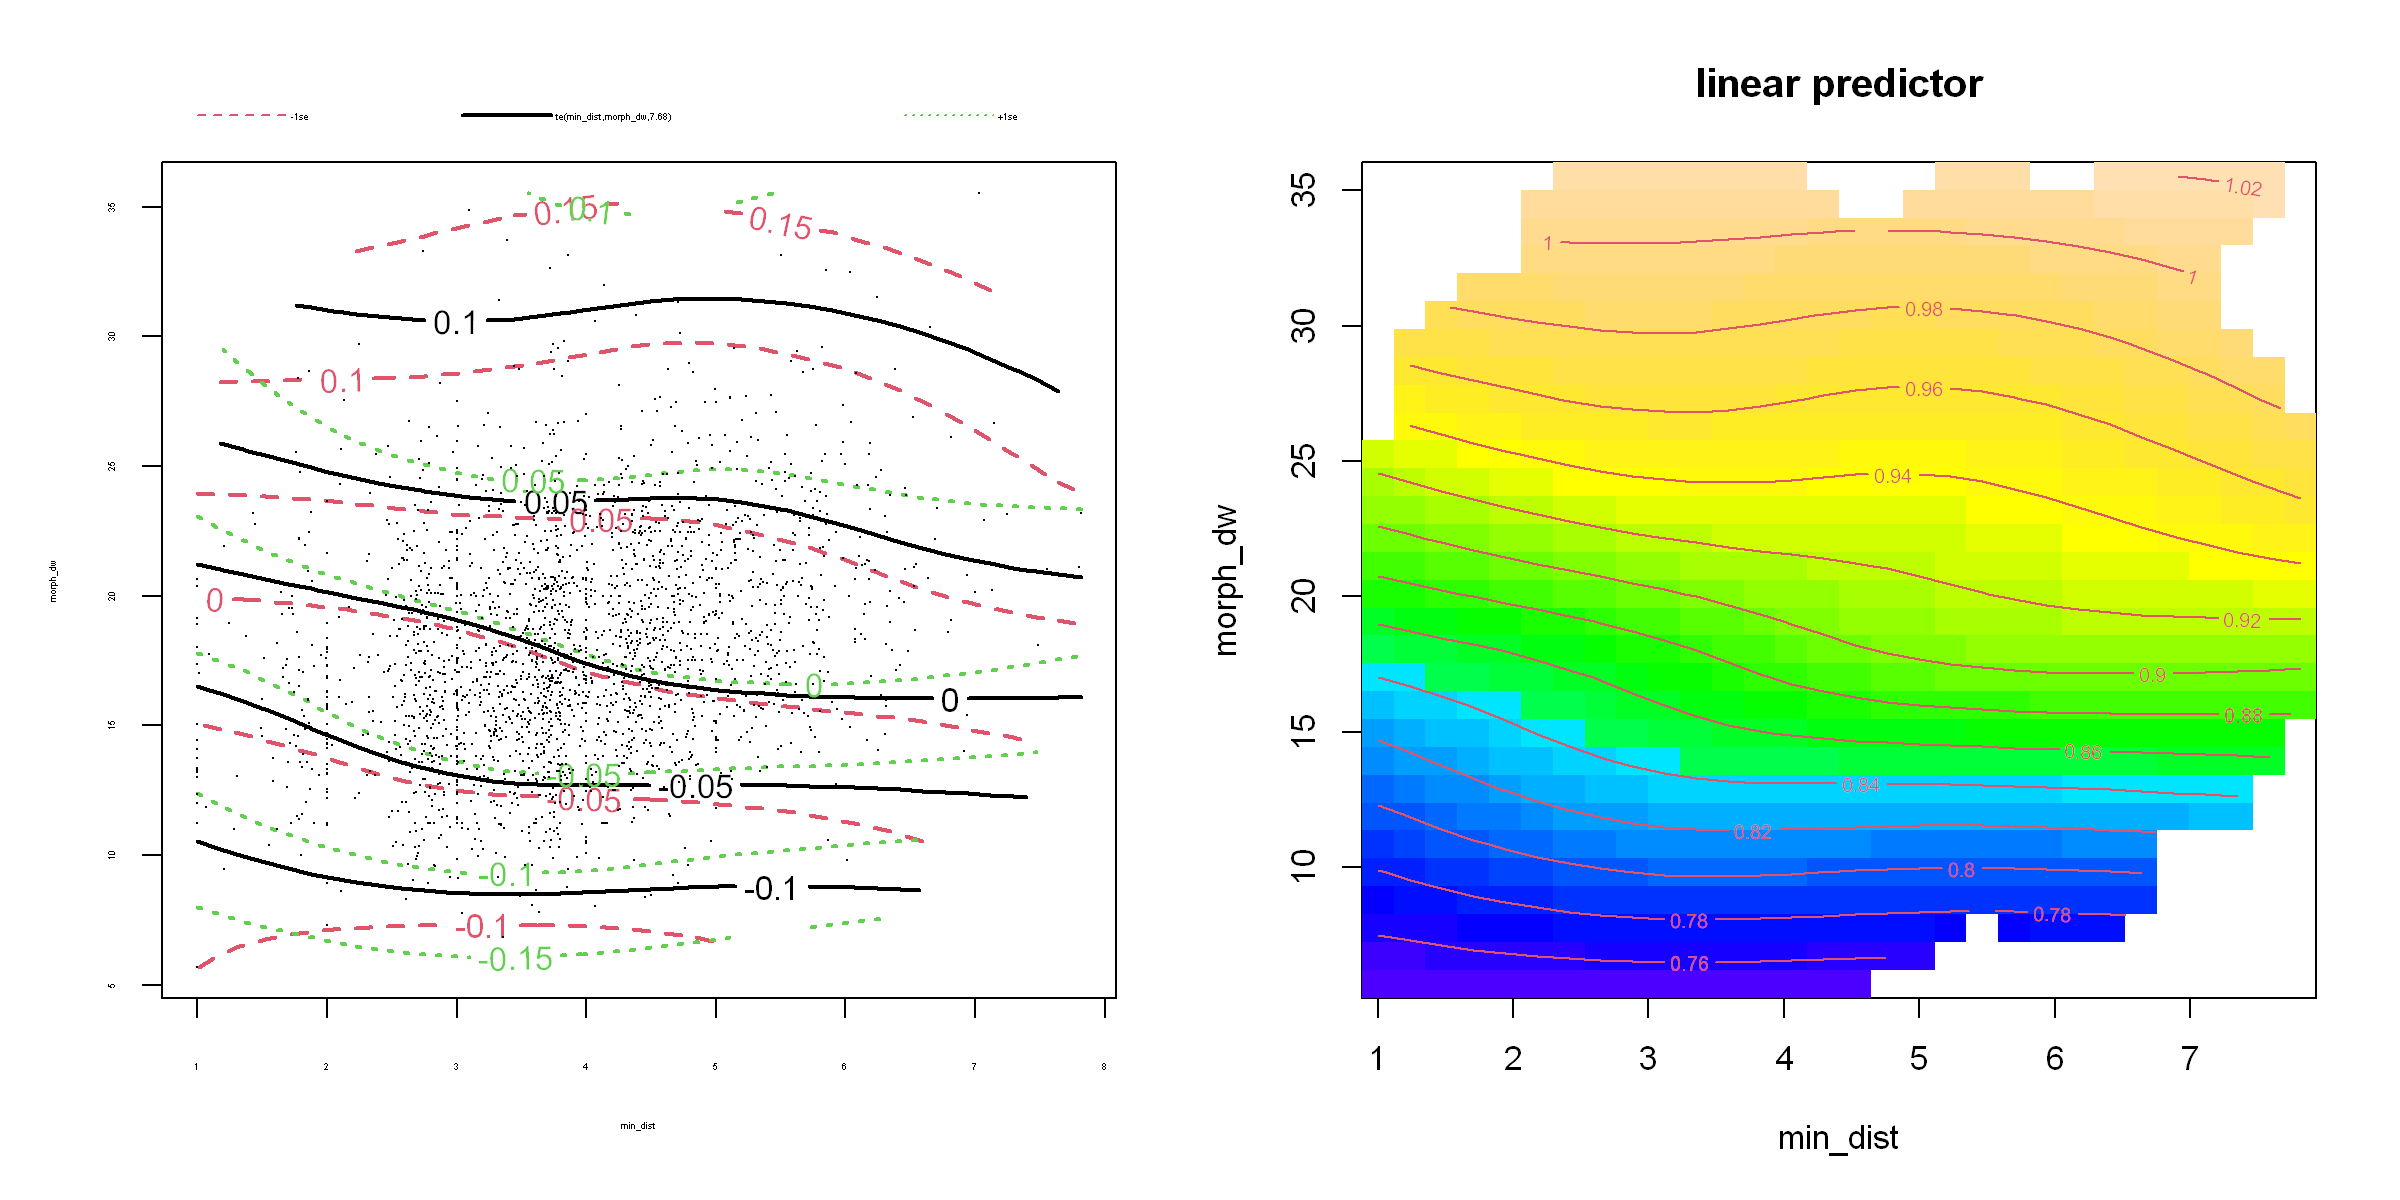

In [162]:
plot_int(ma2.1, 3, "min_dist", "morph_dw")